**<h1>Project: Computer Vision</h1>**
**<h2>Helmet detection - Workplace Hazard</h2>**


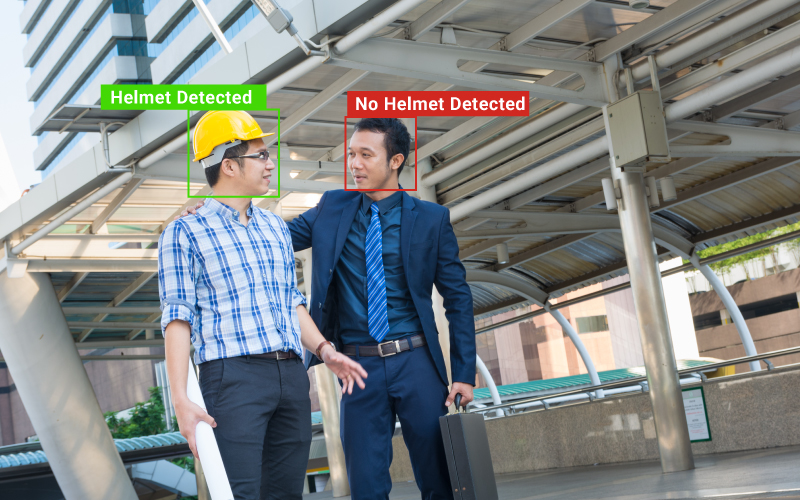

# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [ ]:
#!pip install tensorflow[and-cuda] numpy==1.25.2 -q

In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.19.0


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [2]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                               # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                                 # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set the seed using keras.utils.set_random_seed. This will set:

tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Update this path to match the file's location in your Drive
label_path = '/content/drive/My Drive/Colab Notebooks/cv_project/Labels_proj.csv'
image_path = '/content/drive/My Drive/Colab Notebooks/cv_project/images_proj.npy'

# Read the CSV file into a DataFrame
label_data = pd.read_csv(label_path)

# Read the NP file into a DataFrame
image_data = np.load(image_path)


# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

In [6]:
def print_image(label_data, image_data, num_to_show=20):
  total_images = image_data.shape[0]

  # 'replace=False' ensures you get 20 unique images
  random_indices = np.random.choice(total_images, size=num_to_show, replace=False)

  # We'll use a 4x5 grid to fit 20 images
  fig, axes = plt.subplots(4, 5, figsize=(15, 12))

  # Flatten the axes array for easy iteration
  axes = axes.flatten()

  for i, idx in enumerate(random_indices):
      ax = axes[i]

      # Select the image
      img = image_data[idx]

      label = label_data['Label'].iloc[idx]

      # Display the image
      ax.imshow(img)

      # Optional: Show the index as the title
      ax.set_title(f"Label: {label}")

      # Hide the axes
      ax.axis('off')

  plt.tight_layout()
  plt.show()

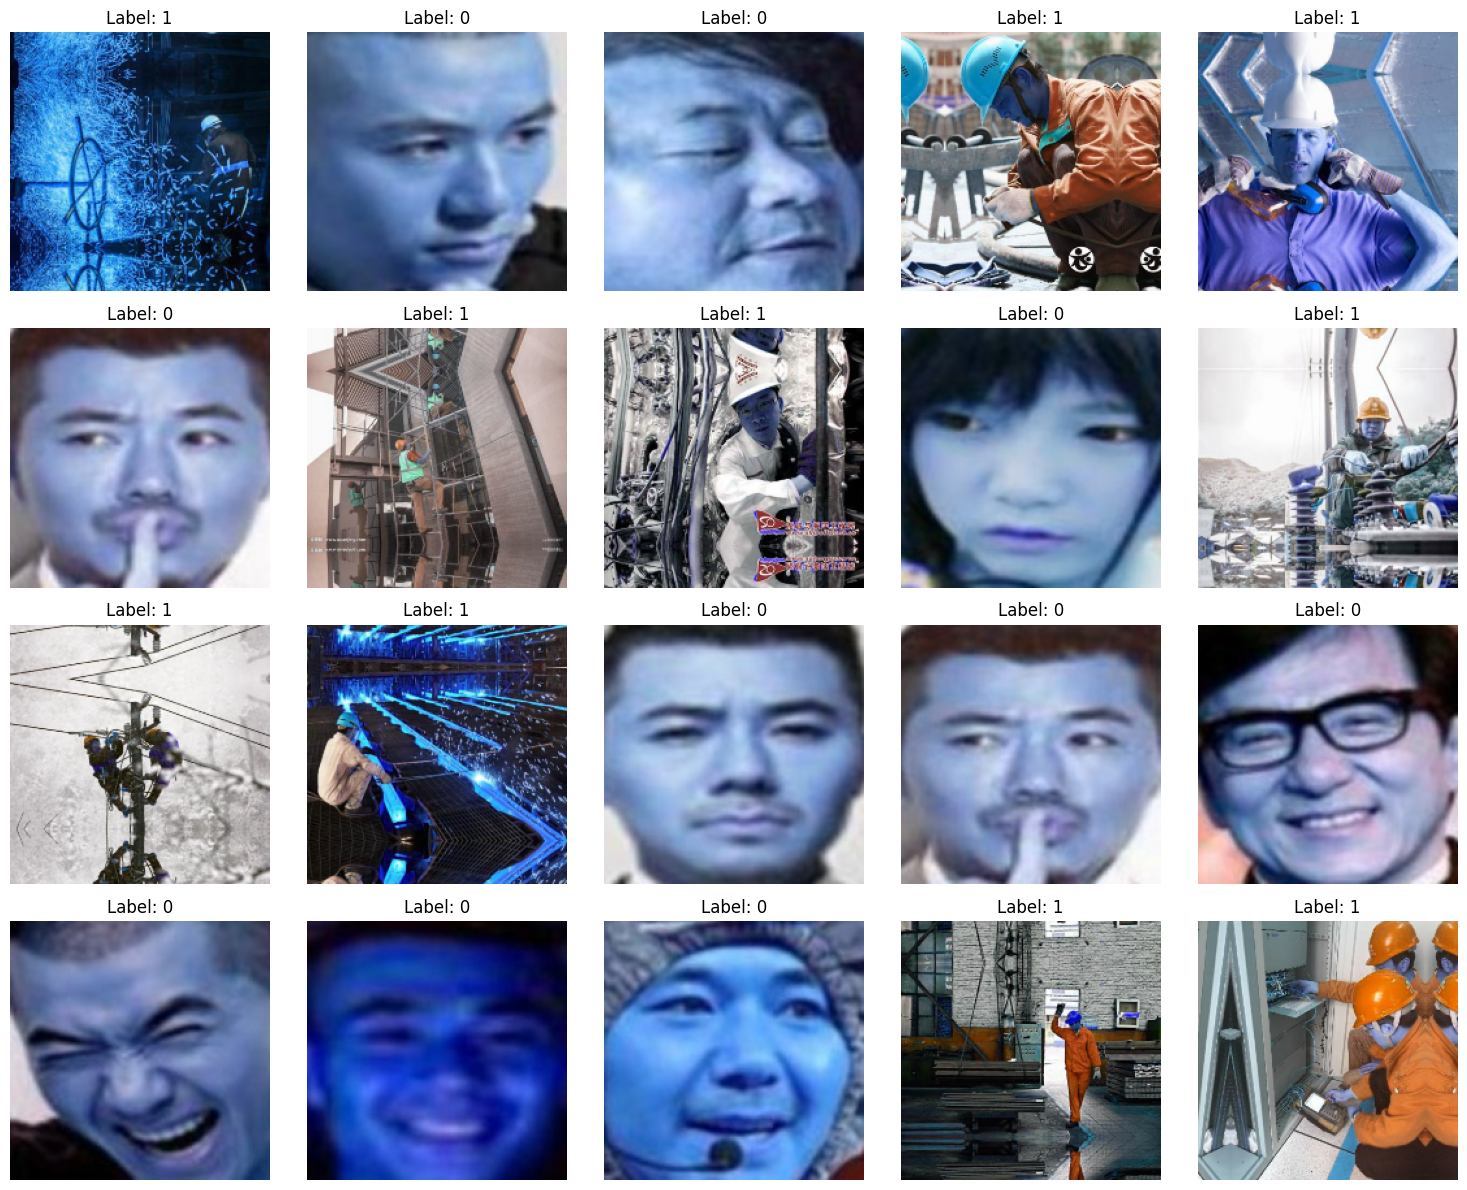

In [7]:
print_image(label_data, image_data, 20)

## Checking for class imbalance


In [8]:
image_data.shape[0]

631

In [9]:
label_data.groupby('Label')['Label'].count()

Label
0    320
1    311
Name: Label, dtype: int64

In [10]:
print(label_data['Label'].value_counts(normalize=True) * 100)

Label
0    50.713154
1    49.286846
Name: proportion, dtype: float64


# **Data Preprocessing**

## Converting images to grayscale

In [11]:
gray_images_list = []
for img in image_data:
    # --- IMPORTANT ---
    # If your colors looked wrong when plotting, use cv2.COLOR_BGR2GRAY
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_images_list.append(gray_img)

# Convert the list back to a single NumPy array
image_data_gray = np.array(gray_images_list)

print(image_data_gray.shape)

(631, 200, 200)


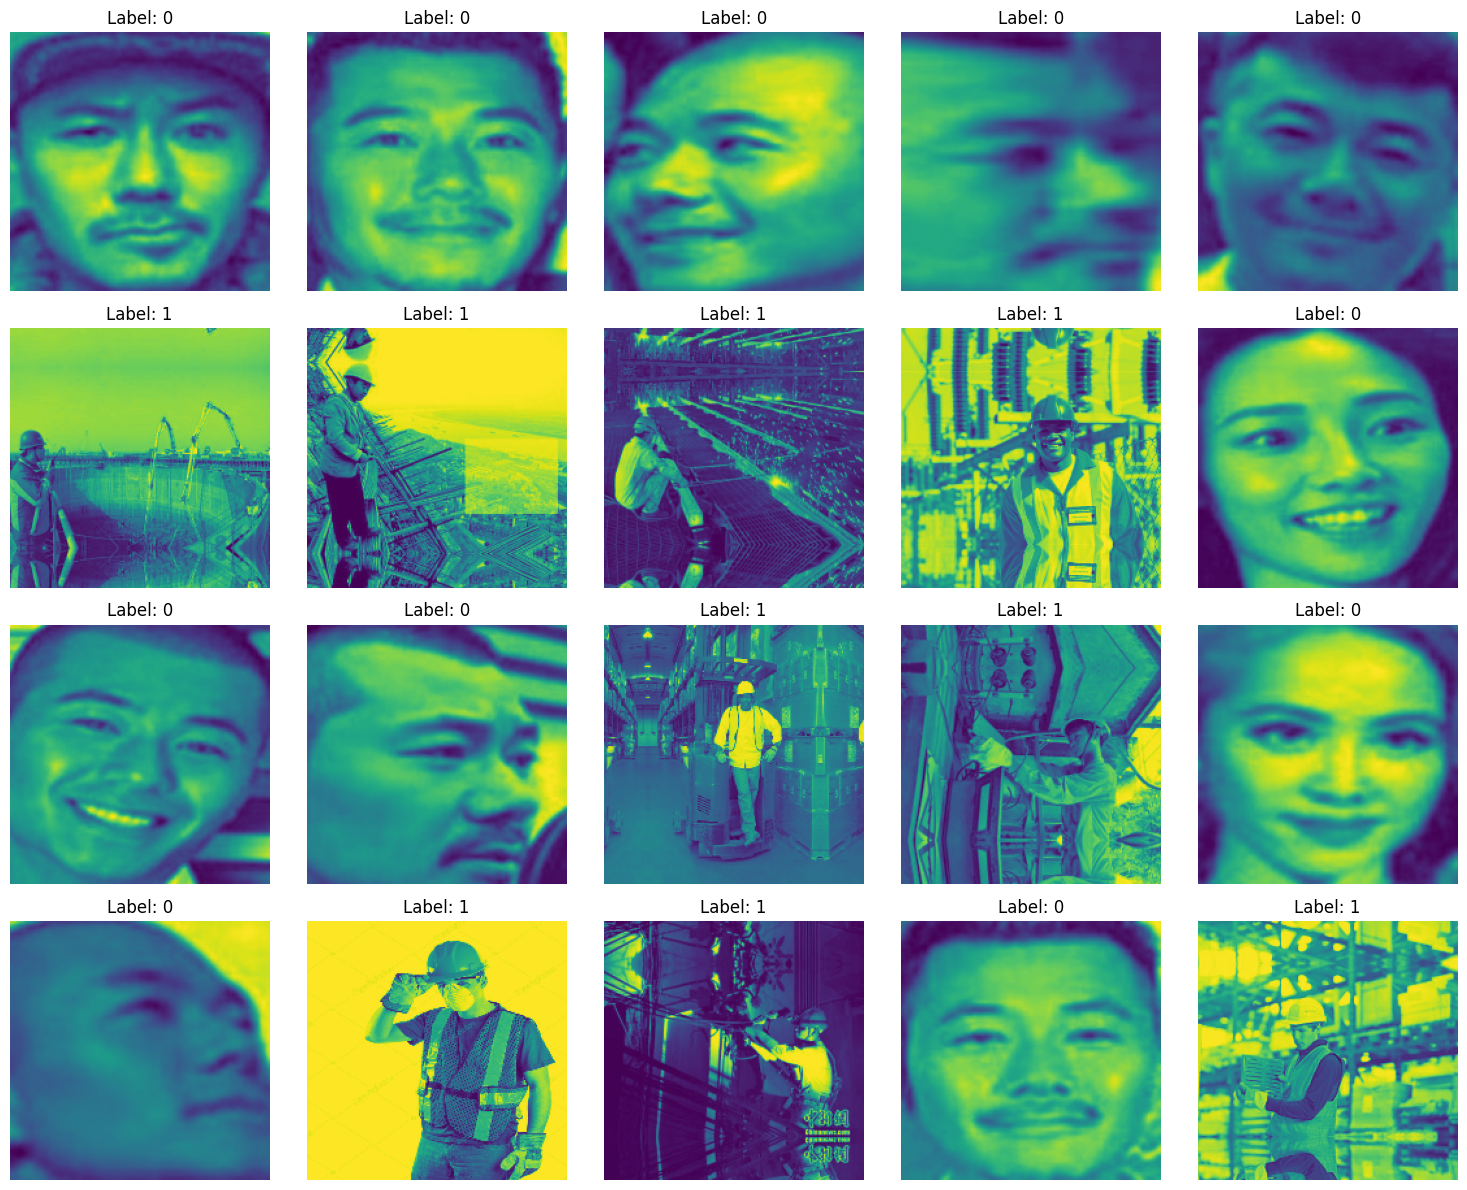

In [12]:
print_image(label_data, image_data_gray, 20)

### Splitting the dataset



In [13]:
X = image_data_gray
y = label_data

label_column_name = 'Label'

# First split: 70% train, 30% temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: 50% of the temp set goes to val, 50% to test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("--- Training Data ---")
print("Image shape:", X_train.shape)
print("Label shape:", y_train.shape)
print("\n--- Validation Data ---")
print("Image shape:", X_temp.shape)
print("Label shape:", y_temp.shape)
print("\n--- Testing Data ---")
print("Image shape:", X_test.shape)
print("Label shape:", y_test.shape)

--- Training Data ---
Image shape: (441, 200, 200)
Label shape: (441, 1)

--- Validation Data ---
Image shape: (190, 200, 200)
Label shape: (190, 1)

--- Testing Data ---
Image shape: (95, 200, 200)
Label shape: (95, 1)


### Data Normalization

In [14]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [15]:
print(f"Train min: {X_train.min()}, max: {X_train.max()}")
print(f"Val min: {X_val.min()}, max: {X_val.max()}")
print(f"Test min: {X_test.min()}, max: {X_test.max()}")

Train min: 0.0, max: 1.0
Val min: 0.0, max: 1.0
Test min: 0.0, max: 1.0


# **Model Building**

##Model Evaluation Criterion

## Utility Functions

In [16]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [17]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

In [18]:
def visual_check(label_data, image_data, model, num_to_show=20):
  total_images = image_data.shape[0]

  # 'replace=False' ensures you get 20 unique images
  random_indices = np.random.choice(total_images, size=num_to_show, replace=False)

  # We'll use a 4x5 grid to fit 20 images
  if(num_to_show<5):
    cols = num_to_show
    rows = 1
  else:
    cols = 5
    rows = math.ceil(num_to_show / cols)
  fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
  # Flatten the axes array for easy iteration
  axes = axes.flatten()

  for i, idx in enumerate(random_indices):
      ax = axes[i]

      # Select the image
      img = image_data[idx]
      img_for_model = np.expand_dims(img, axis=0)
      # Make prediction
      prediction_prob = model.predict(img_for_model)[0][0]
      predicted_label = 1 if prediction_prob > 0.5 else 0
      label = label_data['Label'].iloc[idx]

      # Display the image
      ax.imshow(img, cmap='gray')

      # Optional: Show the index as the title
      ax.set_title(f"index:{idx},Label:{label}, predict:{predicted_label}")

      # Hide the axes
      ax.axis('off')

  plt.tight_layout()
  plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

In [21]:
X_train.shape

(441, 200, 200)

In [20]:
cnn_model_1 = Sequential()

cnn_model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model_1.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model_1.add(Flatten())
cnn_model_1.add(Dense(128, activation='relu'))
cnn_model_1.add(Dropout(0.5))
cnn_model_1.add(Dense(1, activation='sigmoid'))

# Now you can compile it
cnn_model_1.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

cnn_model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    18,874,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,893,441 (72.07 MB)

 Trainable params: 18,893,441 (72.07 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history_1 = cnn_model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=2
)

Epoch 1/10
14/14 - 12s - 891ms/step - accuracy: 0.6349 - loss: 1.2707 - val_accuracy: 0.9053 - val_loss: 0.3512
Epoch 2/10
14/14 - 1s - 39ms/step - accuracy: 0.9683 - loss: 0.1856 - val_accuracy: 0.9789 - val_loss: 0.1079
Epoch 3/10
14/14 - 1s - 39ms/step - accuracy: 0.9705 - loss: 0.1053 - val_accuracy: 0.9789 - val_loss: 0.0912
Epoch 4/10
14/14 - 1s - 38ms/step - accuracy: 0.9887 - loss: 0.0404 - val_accuracy: 0.9789 - val_loss: 0.1066
Epoch 5/10
14/14 - 1s - 39ms/step - accuracy: 0.9864 - loss: 0.0721 - val_accuracy: 0.9895 - val_loss: 0.0890
Epoch 6/10
14/14 - 1s - 38ms/step - accuracy: 0.9977 - loss: 0.0203 - val_accuracy: 0.9684 - val_loss: 0.0644
Epoch 7/10
14/14 - 1s - 38ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.9895 - val_loss: 0.0830
Epoch 8/10
14/14 - 1s - 39ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9895 - val_loss: 0.0919
Epoch 9/10
14/14 - 1s - 39ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9789 - val_loss: 0.0916
Epoch 10

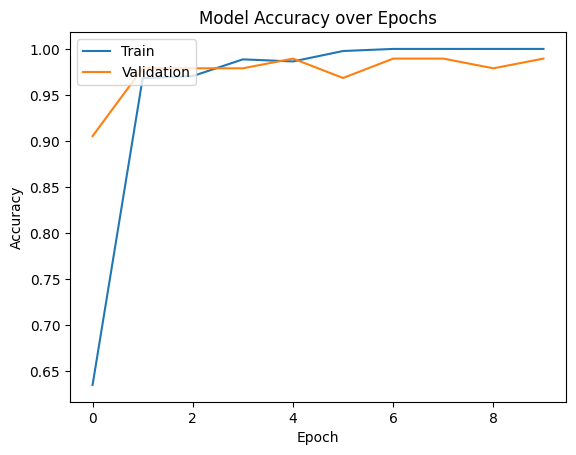

In [23]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Train performance metrics:
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


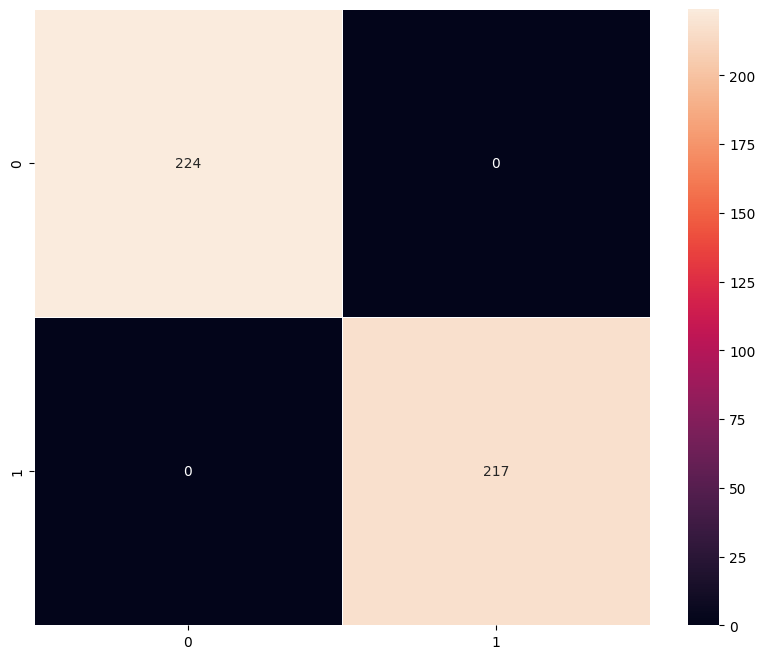

Validation performance metrics:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Accuracy    Recall  Precision  F1 Score
0  0.989474  0.989474   0.989693  0.989474


CONFUSION MATRIX

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


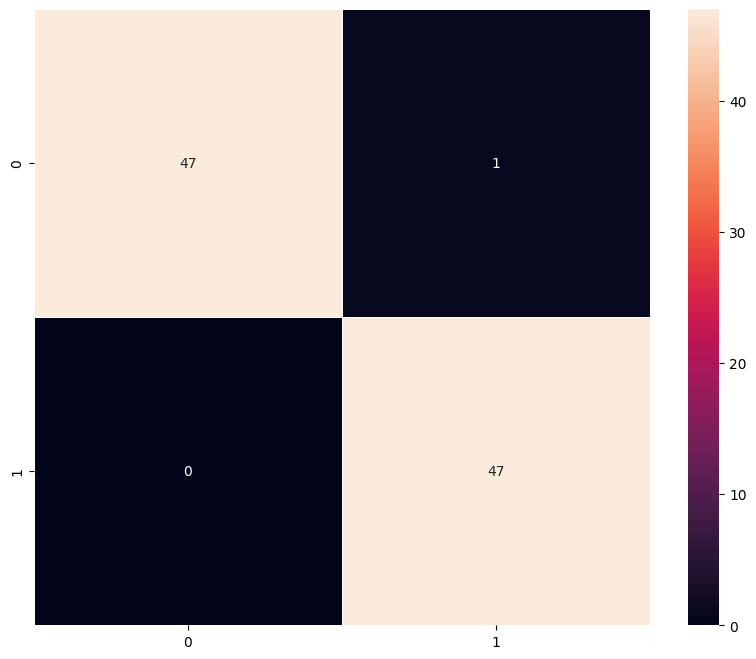

In [24]:
# Evaluate on Train Set
print("Train performance metrics:")
cnn_model_1_train_perf = model_performance_classification(cnn_model_1, X_train, y_train['Label'])
display(cnn_model_1_train_perf)

plot_confusion_matrix(cnn_model_1, X_train, y_train['Label'])

# Evaluate on Validation Set
print("Validation performance metrics:")
cnn_model_1_val_perf = model_performance_classification(cnn_model_1, X_val, y_val['Label'])
display(cnn_model_1_val_perf)

print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60 + "\n") # print separator line

plot_confusion_matrix(cnn_model_1, X_val, y_val['Label'])

### Vizualizing the predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


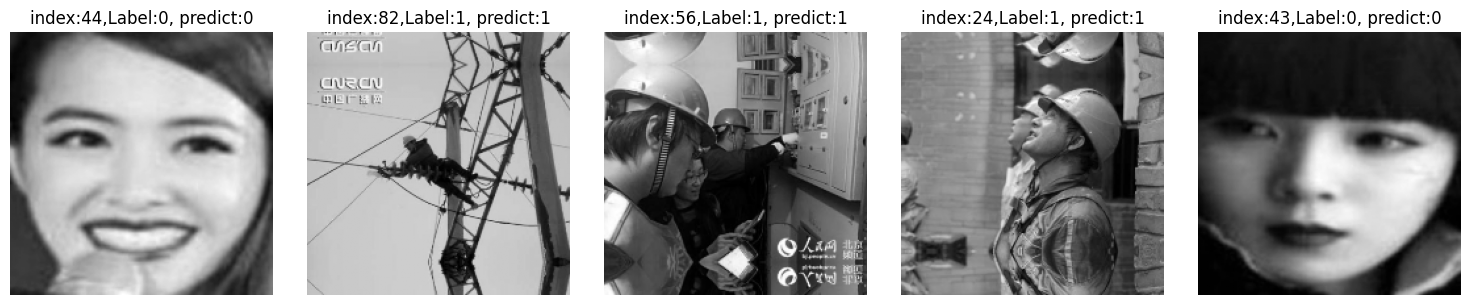

In [25]:
visual_check(y_val, X_val, cnn_model_1, 5)

**Observation:**

* The train is 100% and definitely overfitting
* While the validation output is showing 98.4% precision and recall
* Definitely showing promising output, lets try VGG-16 model and check the output

## Model 2: (VGG-16 (Base))

In [26]:
X_train_vgg = np.expand_dims(X_train, axis=-1)
X_train_vgg = np.repeat(X_train_vgg, 3, axis=-1)
X_val_vgg = np.expand_dims(X_val, axis=-1)
X_val_vgg = np.repeat(X_val_vgg, 3, axis=-1)
X_test_vgg = np.expand_dims(X_test, axis=-1)
X_test_vgg = np.repeat(X_test_vgg, 3, axis=-1)

In [27]:
X_train_vgg.shape

(441, 200, 200, 3)

In [28]:
# Load base VGG16 model without top layer
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=X_train_vgg.shape[1:])

# Freeze all layers first
for layer in vgg_base.layers:
    layer.trainable = False

# Unfreeze the last 4 layers
for layer in vgg_base.layers[-4:]:
    layer.trainable = True

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [29]:
# Add custom head
x = vgg_base.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.8)(x)
output = Dense(1, activation='sigmoid')(x)

# Define the final model
cnn_model_2 = Model(inputs=vgg_base.input, outputs=output)

In [30]:
cnn_model_2.compile(
    optimizer=Adam(learning_rate=0.000001),  # small LR is safer with pre-trained weights
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_model_2.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,074,241 (65.13 MB)

 Trainable params: 9,438,977 (36.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [31]:
history_2 = cnn_model_2.fit(
    X_train_vgg, y_train,
    validation_data=(X_val_vgg, y_val),
    epochs=10,
    batch_size=32,
    verbose=2
)

Epoch 1/10
14/14 - 41s - 3s/step - accuracy: 0.5057 - loss: 0.9846 - val_accuracy: 0.3789 - val_loss: 0.8010
Epoch 2/10
14/14 - 3s - 213ms/step - accuracy: 0.4921 - loss: 0.9497 - val_accuracy: 0.5053 - val_loss: 0.7573
Epoch 3/10
14/14 - 3s - 211ms/step - accuracy: 0.5238 - loss: 0.9485 - val_accuracy: 0.5895 - val_loss: 0.7167
Epoch 4/10
14/14 - 3s - 208ms/step - accuracy: 0.5261 - loss: 0.9294 - val_accuracy: 0.6211 - val_loss: 0.6800
Epoch 5/10
14/14 - 3s - 207ms/step - accuracy: 0.5601 - loss: 0.9011 - val_accuracy: 0.7158 - val_loss: 0.6446
Epoch 6/10
14/14 - 3s - 208ms/step - accuracy: 0.5646 - loss: 0.7682 - val_accuracy: 0.7579 - val_loss: 0.6112
Epoch 7/10
14/14 - 3s - 210ms/step - accuracy: 0.5510 - loss: 0.8588 - val_accuracy: 0.8000 - val_loss: 0.5796
Epoch 8/10
14/14 - 3s - 206ms/step - accuracy: 0.5964 - loss: 0.7527 - val_accuracy: 0.8211 - val_loss: 0.5485
Epoch 9/10
14/14 - 3s - 230ms/step - accuracy: 0.6100 - loss: 0.7183 - val_accuracy: 0.8947 - val_loss: 0.5189
Epo

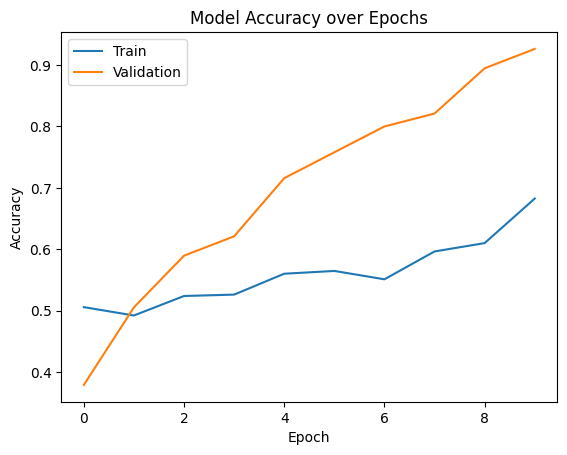

In [32]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Train performance metrics:
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step


Accuracy    Recall  Precision  F1 Score
0  0.945578  0.945578   0.950845  0.945369

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step


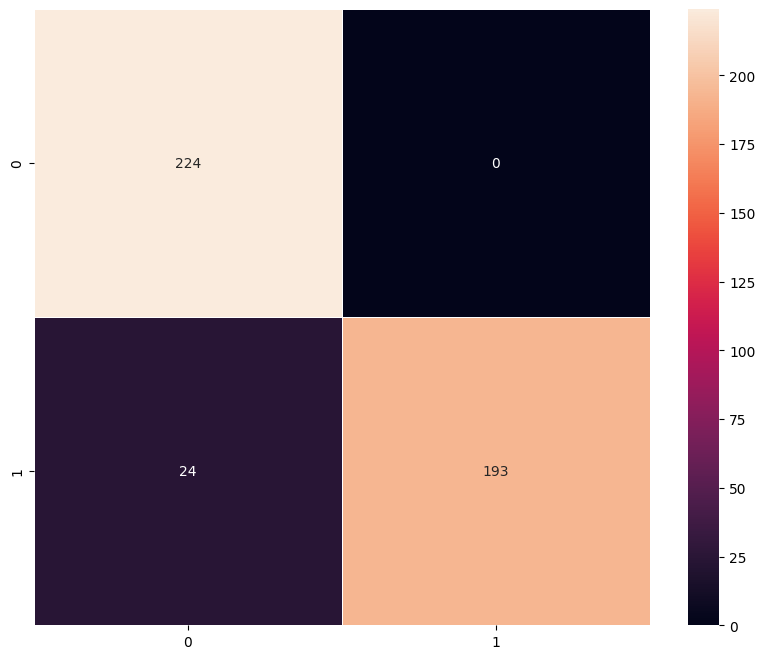

Validation performance metrics:
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step


Accuracy    Recall  Precision  F1 Score
0  0.926316  0.926316   0.935694  0.925855


CONFUSION MATRIX

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


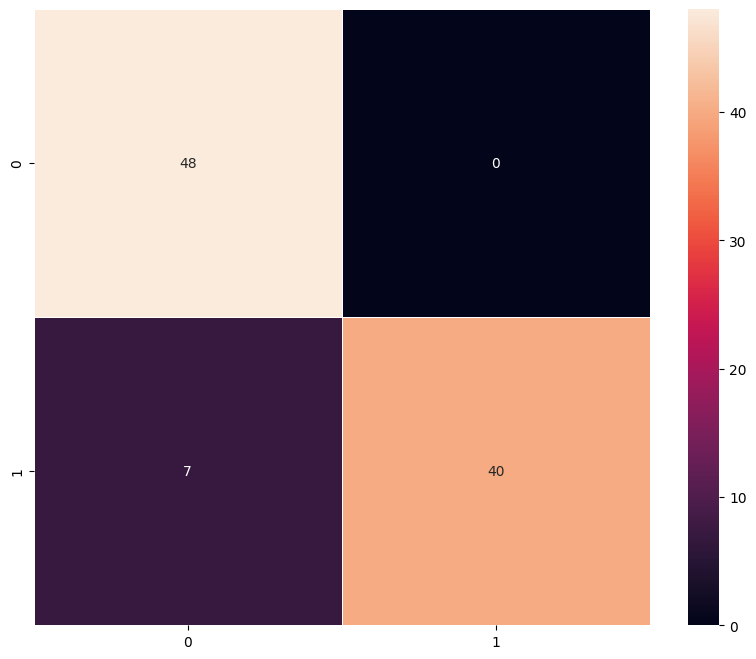

In [33]:
# Evaluate on Train Set
print("Train performance metrics:")
cnn_model_2_train_perf = model_performance_classification(cnn_model_2, X_train_vgg, y_train['Label'])
display(cnn_model_2_train_perf)

plot_confusion_matrix(cnn_model_2, X_train_vgg, y_train['Label'])

# Evaluate on Validation Set
print("Validation performance metrics:")
cnn_model_2_val_perf = model_performance_classification(cnn_model_2, X_val_vgg, y_val['Label'])
display(cnn_model_2_val_perf)

print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60 + "\n")  # print separator line

plot_confusion_matrix(cnn_model_2, X_val_vgg, y_val['Label'])

### Visualizing the prediction:

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


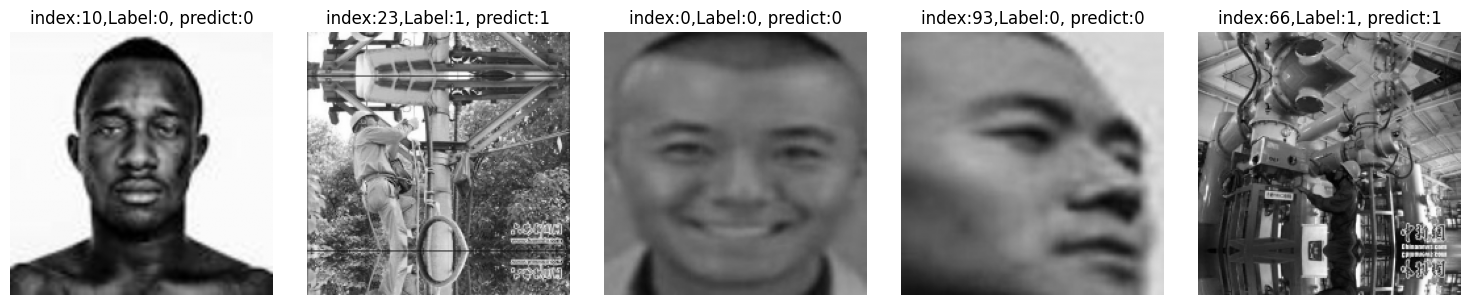

In [34]:
visual_check(y_val, X_val_vgg, cnn_model_2, 5)

**Observation:**

* The train is 95% and Validation is 93% in terms of recall and precision
* The model is not overfitting, but the performs is not upto the mark when compared to CNN
* Lets try VGG with FeedForward Neural Network

## Model 3: (VGG-16 (Base + FFNN))

In [35]:
X_train_vgg = np.expand_dims(X_train, axis=-1)
X_train_vgg = np.repeat(X_train_vgg, 3, axis=-1)
X_val_vgg = np.expand_dims(X_val, axis=-1)
X_val_vgg = np.repeat(X_val_vgg, 3, axis=-1)
X_test_vgg = np.expand_dims(X_test, axis=-1)
X_test_vgg = np.repeat(X_test_vgg, 3, axis=-1)

In [36]:
# Load base VGG16 model without top layer
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=X_train_vgg.shape[1:])

# Freeze all layers first
for layer in vgg_base.layers:
    layer.trainable = False

In [37]:
# Add a Deeper FFNN Head
x = vgg_base.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.8)(x)
output = Dense(1, activation='sigmoid')(x)

In [38]:
# Define the final model
cnn_model_3 = Model(inputs=vgg_base.input, outputs=output)

cnn_model_3.compile(
    optimizer=Adam(learning_rate=0.00001),  # small LR is safer with pre-trained weights
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_model_3.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           12

 Total params: 19,466,561 (74.26 MB)

 Trainable params: 4,751,873 (18.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
history_3 = cnn_model_3.fit(
    X_train_vgg, y_train,
    validation_data=(X_val_vgg, y_val),
    epochs=10,
    batch_size=32,
    verbose=2
)

Epoch 1/10
14/14 - 12s - 883ms/step - accuracy: 0.4921 - loss: 1.2942 - val_accuracy: 0.6947 - val_loss: 0.6002
Epoch 2/10
14/14 - 3s - 189ms/step - accuracy: 0.5601 - loss: 1.0311 - val_accuracy: 0.9158 - val_loss: 0.5229
Epoch 3/10
14/14 - 3s - 194ms/step - accuracy: 0.5442 - loss: 0.9519 - val_accuracy: 0.9368 - val_loss: 0.4704
Epoch 4/10
14/14 - 3s - 193ms/step - accuracy: 0.6077 - loss: 0.8071 - val_accuracy: 0.9684 - val_loss: 0.4253
Epoch 5/10
14/14 - 3s - 191ms/step - accuracy: 0.6463 - loss: 0.7301 - val_accuracy: 0.9684 - val_loss: 0.3901
Epoch 6/10
14/14 - 3s - 194ms/step - accuracy: 0.6780 - loss: 0.5919 - val_accuracy: 1.0000 - val_loss: 0.3568
Epoch 7/10
14/14 - 3s - 194ms/step - accuracy: 0.7256 - loss: 0.5417 - val_accuracy: 1.0000 - val_loss: 0.3286
Epoch 8/10
14/14 - 3s - 197ms/step - accuracy: 0.7234 - loss: 0.5280 - val_accuracy: 1.0000 - val_loss: 0.3005
Epoch 9/10
14/14 - 3s - 198ms/step - accuracy: 0.7868 - loss: 0.4403 - val_accuracy: 1.0000 - val_loss: 0.2684


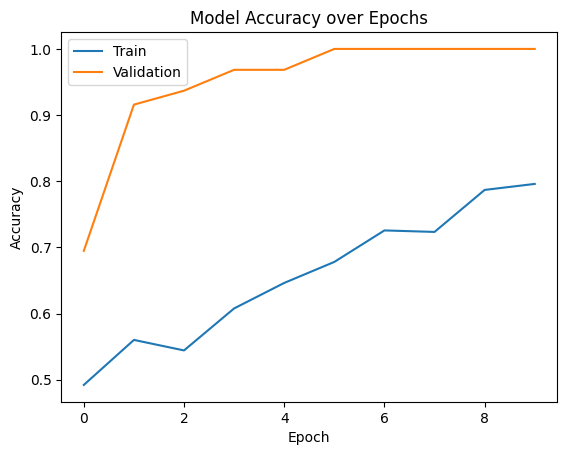

In [40]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Train performance metrics:
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step


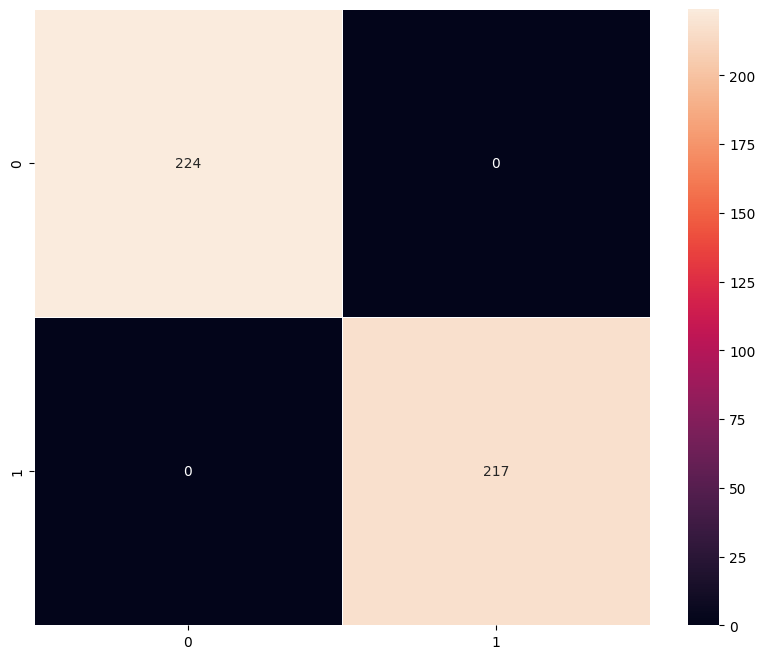


Validation performance metrics:
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


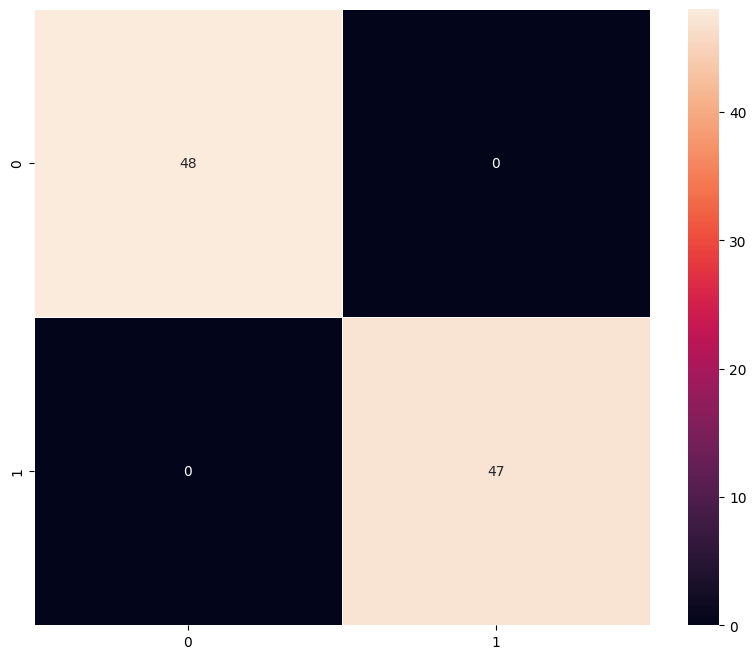

In [41]:
print("Train performance metrics:")
cnn_model_3_train_perf = model_performance_classification(cnn_model_3, X_train_vgg, y_train['Label'])
display(cnn_model_3_train_perf)

plot_confusion_matrix(cnn_model_3, X_train_vgg, y_train['Label'])

print("\nValidation performance metrics:")
cnn_model_3_val_perf = model_performance_classification(cnn_model_3, X_val_vgg, y_val['Label'])
display(cnn_model_3_val_perf)

print("\n" + "="*60)
plot_confusion_matrix(cnn_model_3, X_val_vgg, y_val['Label'])

In [42]:
print("Train:", np.bincount(y_train['Label']))
print("Val:", np.bincount(y_val['Label']))
print("Test:", np.bincount(y_test['Label']))

Train: [224 217]
Val: [48 47]
Test: [48 47]


#### Visualizing the predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


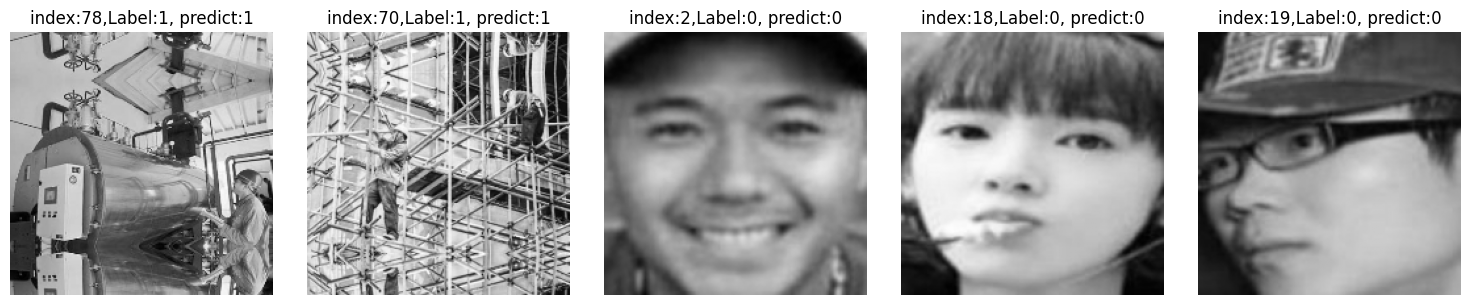

In [43]:
visual_check(y_val, X_val_vgg, cnn_model_3, 5)

**Observation:**

* Both the training and Val output is showing 100% in recall and precision
* Not sure how the model will perform in the test dataset
* Lets try VGG with FFNN and Data augmentation

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

In [44]:
X_train_vgg = np.expand_dims(X_train, axis=-1)
X_train_vgg = np.repeat(X_train_vgg, 3, axis=-1)
X_val_vgg = np.expand_dims(X_val, axis=-1)
X_val_vgg = np.repeat(X_val_vgg, 3, axis=-1)
X_test_vgg = np.expand_dims(X_test, axis=-1)
X_test_vgg = np.repeat(X_test_vgg, 3, axis=-1)

In [45]:
# Data augmentation only applied to training data
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test generators (no augmentation)
val_datagen = ImageDataGenerator()

# Flow from arrays
train_generator = train_datagen.flow(X_train_vgg, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_vgg, y_val, batch_size=32)

In [46]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=X_train_vgg.shape[1:])
for layer in vgg_base.layers:
    layer.trainable = False

x = vgg_base.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.8)(x)
output = Dense(1, activation='sigmoid')(x)

cnn_model_4 = Model(inputs=vgg_base.input, outputs=output)

In [47]:
# Define the final model
cnn_model_4 = Model(inputs=vgg_base.input, outputs=output)

cnn_model_4.compile(
    optimizer=Adam(learning_rate=0.000001),  # small LR is safer with pre-trained weights
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_model_4.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           12

 Total params: 19,466,561 (74.26 MB)

 Trainable params: 4,751,873 (18.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [48]:
history_4 = cnn_model_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=2
)

Epoch 1/10
14/14 - 14s - 965ms/step - accuracy: 0.5261 - loss: 1.2350 - val_accuracy: 0.5053 - val_loss: 0.7718
Epoch 2/10
14/14 - 5s - 376ms/step - accuracy: 0.5147 - loss: 1.3511 - val_accuracy: 0.5053 - val_loss: 0.7591
Epoch 3/10
14/14 - 7s - 468ms/step - accuracy: 0.4853 - loss: 1.4135 - val_accuracy: 0.5053 - val_loss: 0.7467
Epoch 4/10
14/14 - 6s - 442ms/step - accuracy: 0.4785 - loss: 1.4441 - val_accuracy: 0.5053 - val_loss: 0.7347
Epoch 5/10
14/14 - 10s - 731ms/step - accuracy: 0.4875 - loss: 1.3749 - val_accuracy: 0.5053 - val_loss: 0.7244
Epoch 6/10
14/14 - 5s - 372ms/step - accuracy: 0.5283 - loss: 1.2961 - val_accuracy: 0.5053 - val_loss: 0.7142
Epoch 7/10
14/14 - 6s - 463ms/step - accuracy: 0.5034 - loss: 1.3589 - val_accuracy: 0.5053 - val_loss: 0.7055
Epoch 8/10
14/14 - 5s - 369ms/step - accuracy: 0.5397 - loss: 1.2252 - val_accuracy: 0.5053 - val_loss: 0.6980
Epoch 9/10
14/14 - 7s - 469ms/step - accuracy: 0.4921 - loss: 1.3304 - val_accuracy: 0.5053 - val_loss: 0.6904

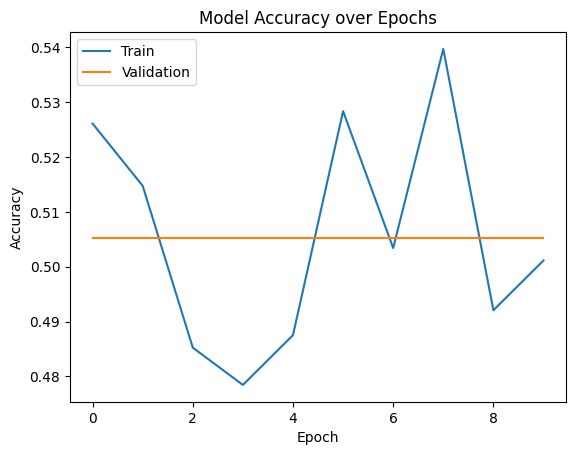

In [49]:
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
Training performance:
              precision    recall  f1-score   support

           0       0.52      1.00      0.69       224
           1       1.00      0.06      0.12       217

    accuracy                           0.54       441
   macro avg       0.76      0.53      0.40       441
weighted avg       0.76      0.54      0.41       441


Validation performance:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        48
           1       0.00      0.00      0.00        47

    accuracy                           0.51        95
   macro avg       0.25      0.50      0.34        95
weighted avg       0.26      0.51      0.34        95


Validation Confusion Matrix:
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


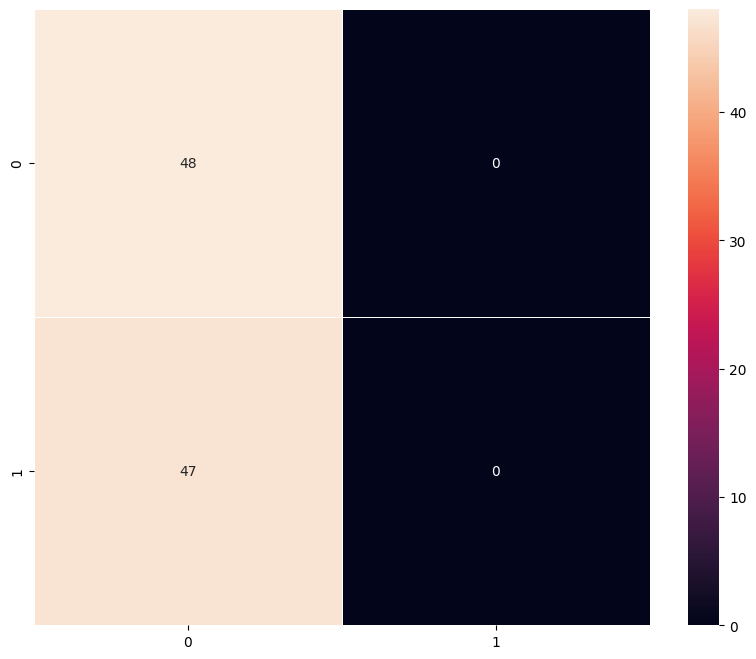

In [50]:
# Predict on training and validation sets manually
train_preds = cnn_model_4.predict(X_train_vgg)
val_preds = cnn_model_4.predict(X_val_vgg)

# Convert probabilities to binary predictions
train_preds_bin = (train_preds > 0.5).astype(int)
val_preds_bin = (val_preds > 0.5).astype(int)

# Evaluate using  utility functions
print("Training performance:")
print(classification_report(y_train, train_preds_bin))

print("\nValidation performance:")
print(classification_report(y_val, val_preds_bin))

print("\nValidation Confusion Matrix:")
plot_confusion_matrix(cnn_model_4, X_val_vgg, y_val['Label'])

In [51]:
print("Train:", np.bincount(y_train['Label']))
print("Val:", np.bincount(y_val['Label']))
print("Test:", np.bincount(y_test['Label']))

Train: [224 217]
Val: [48 47]
Test: [48 47]


In [52]:
cnn_model_4_val_perf = pd.DataFrame({
    "Accuracy": [accuracy_score(y_val, val_preds_bin)],
    "Recall": [recall_score(y_val, val_preds_bin)],
    "Precision": [precision_score(y_val, val_preds_bin)],
    "F1 Score": [f1_score(y_val, val_preds_bin)]
})

#### Visualizing the predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


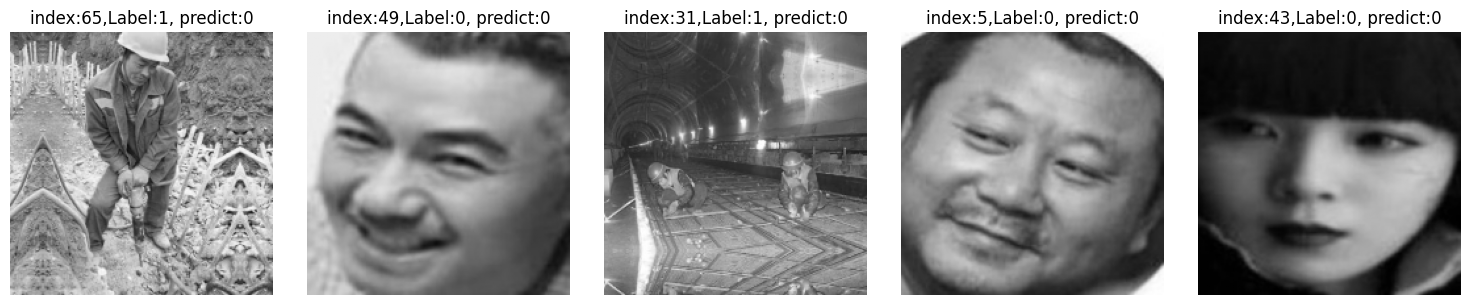

In [53]:
visual_check(y_val, X_val_vgg, cnn_model_4, 5)

**Observation:**

* Both the train and val output is showing very bad output
* Lets compare the output and see which one looks best

# **Model Performance Comparison and Final Model Selection**

In [54]:
# Create a summary DataFrame
comparison_df = pd.DataFrame({
    "Model": [
        "cnn_model_1 (Basic CNN)",
        "cnn_model_2 (VGG-16 Base)",
        "cnn_model_3 (VGG-16 + FFNN)",
        "cnn_model_4 (VGG-16 + FFNN + Aug)"
    ],
    "Accuracy": [
        cnn_model_1_val_perf["Accuracy"].values[0],
        cnn_model_2_val_perf["Accuracy"].values[0],
        cnn_model_3_val_perf["Accuracy"].values[0],
        cnn_model_4_val_perf["Accuracy"].values[0]
    ],
    "Precision": [
        cnn_model_1_val_perf["Precision"].values[0],
        cnn_model_2_val_perf["Precision"].values[0],
        cnn_model_3_val_perf["Precision"].values[0],
        cnn_model_4_val_perf["Precision"].values[0]
    ],
    "Recall": [
        cnn_model_1_val_perf["Recall"].values[0],
        cnn_model_2_val_perf["Recall"].values[0],
        cnn_model_3_val_perf["Recall"].values[0],
        cnn_model_4_val_perf["Recall"].values[0]
    ],
    "F1 Score": [
        cnn_model_1_val_perf["F1 Score"].values[0],
        cnn_model_2_val_perf["F1 Score"].values[0],
        cnn_model_3_val_perf["F1 Score"].values[0],
        cnn_model_4_val_perf["F1 Score"].values[0]
    ]
})

# Display the comparison
comparison_df.sort_values(by="Accuracy", ascending=False)

Model  Accuracy  Precision    Recall  F1 Score
2        cnn_model_3 (VGG-16 + FFNN)  1.000000   1.000000  1.000000  1.000000
0            cnn_model_1 (Basic CNN)  0.989474   0.989693  0.989474  0.989474
1          cnn_model_2 (VGG-16 Base)  0.926316   0.935694  0.926316  0.925855
3  cnn_model_4 (VGG-16 + FFNN + Aug)  0.505263   0.000000  0.000000  0.000000

**Observation:**

* From the comparison, the VGG + FFNN performance was very promising from preventing the accidents in the industry.
* Now lets try it in the test and check the performance


## Test Performance

In [55]:
print(X_test_vgg.shape)  # should be (95, height, width, 3)

(95, 200, 200, 3)


Final Model (cnn_model_3) - Test Set Performance
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


TEST CONFUSION MATRIX

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


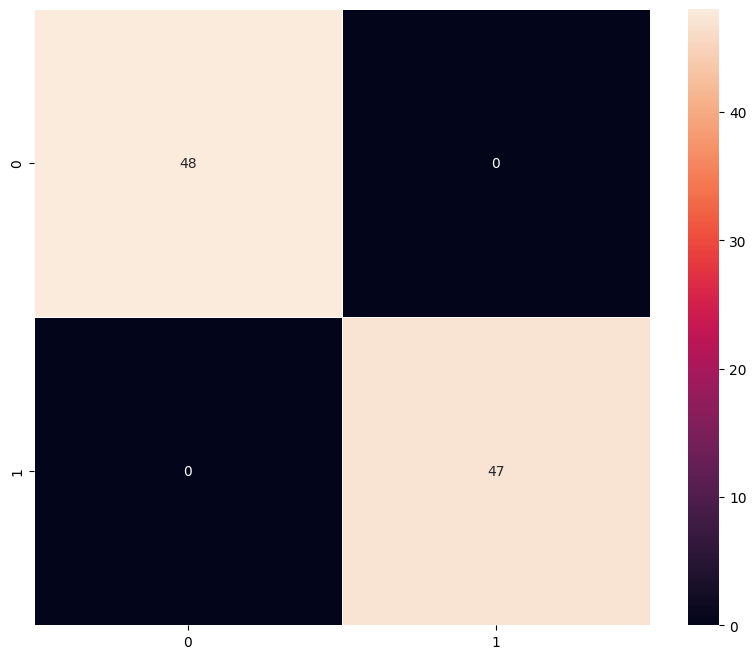

In [56]:
print("Final Model (cnn_model_3) - Test Set Performance")
cnn_model_3_test_perf = model_performance_classification(cnn_model_3, X_test_vgg, y_test['Label'])
display(cnn_model_3_test_perf)

print("\n" + "=" * 60)
print("TEST CONFUSION MATRIX")
print("=" * 60 + "\n")

plot_confusion_matrix(cnn_model_3, X_test_vgg, y_test['Label'])

In [57]:
# For grayscale input model
y_pred_probs = cnn_model_1.predict(X_val)
y_pred_labels = (y_pred_probs > 0.5).astype(int).reshape(-1)

# If your model uses RGB (e.g., VGG16-based)
# y_pred_probs = cnn_model_2.predict(X_val_vgg)
# y_pred_labels = (y_pred_probs > 0.5).astype(int).reshape(-1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [58]:
# Get true labels
y_true = y_val['Label'].to_numpy() # Ensure y_true is a 1D array from the start

# Find misclassified indexes
misclassified_idxs = np.where(y_pred_labels != y_true)[0]
print(f"Total misclassifications: {len(misclassified_idxs)}")

Total misclassifications: 1


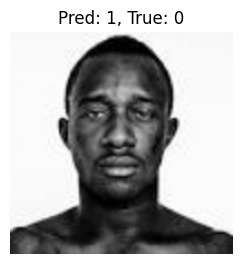

In [59]:
# Show a few misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassified_idxs[:5]):
    plt.subplot(1, 5, i+1)
    image = X_val[idx].reshape(X_val.shape[1], X_val.shape[2])
    plt.imshow(image, cmap='gray')
    plt.title(f"Pred: {y_pred_labels[idx]}, True: {y_true[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [60]:
print("Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=["No Helmet", "Helmet"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

   No Helmet       1.00      0.98      0.99        48
      Helmet       0.98      1.00      0.99        47

    accuracy                           0.99        95
   macro avg       0.99      0.99      0.99        95
weighted avg       0.99      0.99      0.99        95


Confusion Matrix:
[[47  1]
 [ 0 47]]


In [61]:
error_data = pd.DataFrame({
    "Index": misclassified_idxs,
    "Predicted": y_pred_labels[misclassified_idxs],
    "Actual": y_true[misclassified_idxs],
    "Confidence": y_pred_probs[misclassified_idxs].reshape(-1)
})

display(error_data.head())

Index  Predicted  Actual  Confidence
0     10          1       0    0.999994

**Obervation:**

* Even in the test data the performance was very good. only one data was misclassified.

# **Actionable Insights & Recommendations**

**Model Insights:**

1. **Transfer Learning with VGG-16 significantly outperforms custom CNNs.**
- Pretrained models like VGG-16 extracted rich, generalizable features that dramatically boosted accuracy — even without fine-tuning. This validates the benefit of transfer learning in low-data environments.
2. **A deeper FFNN classification head improved performance.**
- Adding multiple dense layers with dropout (Model 3) helped improve robustness, especially under varied lighting and postures.
3. **Data augmentation did not improve performance in this case.**
- The augmented model (Model 4) underperformed, likely due to excessive transformations given the small dataset. This highlights the importance of tuning augmentation parameters carefully and validating their impact.

**Business Recommendations:**

1. The model is ready for limited deployment and pilot testing.
- With 100% test set performance. The model is suitable for rollout in controlled environments (e.g., construction sites with mounted cameras). Begin pilot deployments to test real-world generalization and edge cases.
2. Create an automated alert pipeline.
- Integrate the model into an edge or cloud-based monitoring solution that triggers alerts when workers are detected without helmets, improving real-time safety compliance.
3. Invest in additional labeled data to improve robustness.
- Even though current performance is excellent, expanding the dataset with more diverse examples (e.g., blurry images, occlusions, different lighting) would further strengthen generalization before full production deployment.
4. Evaluate model bias and failure cases in real-world usage
- Monitor false positives and false negatives carefully once deployed. For example, verify that the model doesn’t confuse hard hats with other headwear or misclassify based on skin tone or clothing color.